## Part 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import time
import numba
np.random.seed(42)

In [ ]:
# Task 1 - Generate data

def lorenz_step(t, x, y, z, dt, sigma, rho, beta):
    """Calculate the next step in the Lorenz system."""
    dx = sigma * (y - x) * dt
    dy = (x * (rho - z) - y) * dt
    dz = (x * y - beta * z) * dt

    return t + dt, x + dx, y + dy, z + dz


def lorenz(t0, x0, y0, z0, dt, sigma, rho, beta, iter_num):
    """Calculate the evolution of the Lorenz system."""
    t = np.zeros(iter_num + 1)
    x = np.zeros(iter_num + 1)
    y = np.zeros(iter_num + 1)
    z = np.zeros(iter_num + 1)

    t[0], x[0], y[0], z[0] = t0, x0, y0, z0
    for i in range(iter_num):
        t[i + 1], x[i + 1], y[i + 1], z[i + 1] = lorenz_step(t[i], x[i], y[i], z[i], dt, sigma, rho, beta)

    return t, x, y, z

sigma = 10
rho = 28
beta = 8 / 3
dt = 0.01
iter_num = 5_000

t, x1, x2, x3 = lorenz(0, 1, 1, 1, dt, sigma, rho, beta, iter_num)


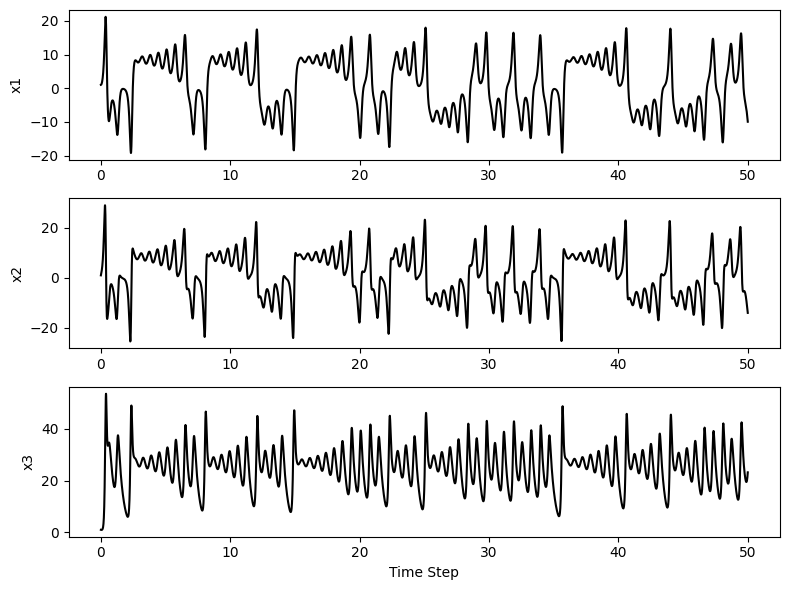

In [ ]:
# Plot time series
fig, axs = plt.subplots(3, 1, figsize=(8, 6))

axs[0].plot(t, x1, label="x1", color="k")
axs[0].set_ylabel("x1")

axs[1].plot(t, x2, label="x2", color="k")
axs[1].set_ylabel("x2")

axs[2].plot(t, x3, label="z3", color="k")
axs[2].set_ylabel("x3")

axs[2].set_xlabel("Time Step")

fig.tight_layout()
plt.show()

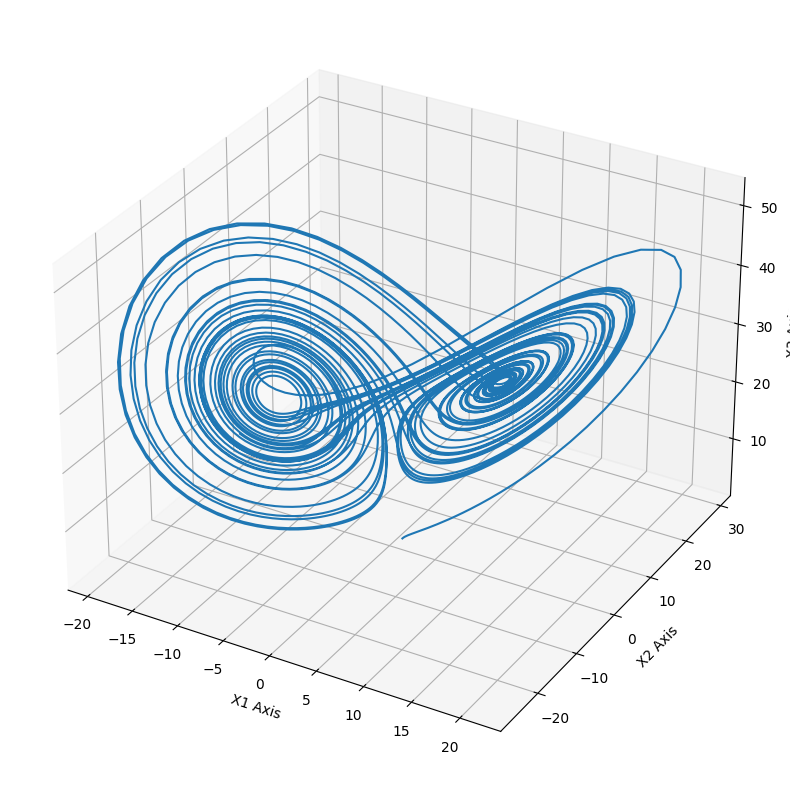

In [ ]:
# Plot Lorenz attractor
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection="3d")
ax.plot(x1, x2, x3)
ax.set_xlabel("X1 Axis")
ax.set_ylabel("X2 Axis")
ax.set_zlabel("X3 Axis")
plt.show()

## Part 2

In [ ]:
# Define reservoir computer

class ReservoirComputer():
    def __init__(self, oi_size, reservoir_size, sparsity, reg_coeff, w_in_scale, sv_max, normalize_inputs=False):
        np.random.seed(42)
        self.io_size = io_size
        self.reservoir_size = reservoir_size
        self.sparsity = sparsity
        self.reg_coeff = reg_coeff
        self.sv_max = sv_max
        self.w_in_scale = w_in_scale
        self.normalize_inputs = normalize_inputs

        # Initalize reservoir state to zeros
        self.reservoir_state = np.zeros(self.reservoir_size)

        initialization = 'U'
        # Generate input weights
        if initialization == 'U':
            # Uniform distribution
            self.W_in = np.random.uniform(-1, 1, (self.reservoir_size, self.io_size))
            self.W_in *= self.w_in_scale
        elif initialization == 'G':
            # Gaussian distributions
            mean = 0.0
            std_dev = 0.01
            self.W_in = np.random.normal(mean, std_dev, size=(self.reservoir_size, self.io_size))
        else:
            raise NotImplementedError

        # Generate reservoir weights
        if initialization == 'U':
            # Uniform distributions
            self.W_res = np.random.uniform(-1, 1, (self.reservoir_size, self.reservoir_size))
        elif initialization == 'G':
            mean = 0.0
            std_dev = 1.0
            self.W_res = np.random.normal(mean, std_dev, (self.reservoir_size, self.reservoir_size))
        else:
            raise NotImplementedError

        # Enforce sparsity
        mask = np.random.rand(reservoir_size, reservoir_size) > sparsity
        self.W_res[mask] = 0

        # Normalize W_res using the maximum singular value
        S = np.linalg.svd(self.W_res, compute_uv=False)
        smax = S[0]
        self.W_res *= self.sv_max / smax

    def normalize_inputs(self, inputs):
        # Normalize input to [-1, 1]
        min_val = np.min(inputs, axis=0)
        max_val = np.max(inputs, axis=0)
        self.normalizations = (min_val, max_val)
        return ((inputs - min_val) / (max_val - min_val)) * 2 - 1

    def reverse_normalize(self, predictions):
        min_val, max_val = self.normalizations
        return ((predictions + 1) / 2) * (max_val - min_val) + min_val

    def train(self, inputs):
        if self.normalize_inputs:
            inputs = self.normalize_inputs(inputs)

        n_time_steps = inputs.shape[0]
        R = np.zeros((self.reservoir_size, n_time_steps))

        # Update reservoir state for each input
        for i in range(n_time_steps):
            R[:, i] = self.reservoir_state
            self.reservoir_state = np.tanh(self.W_res @ self.reservoir_state + self.W_in @ inputs[i, :])

        # Ridge regression to find output weights
        A = R @ R.T + self.reg_coeff * np.identity(self.reservoir_size)
        b = R @ inputs
        self.W_out = np.linalg.solve(A, b).T

    def predict(self, n_predictions):
        predictions = np.zeros((n_predictions, self.io_size))
        for i in range(n_predictions):
            predictions[i, :] = self.W_out @ self.reservoir_state
            self.reservoir_state = np.tanh(self.W_res @ self.reservoir_state + self.W_in @ predictions[i, :])

        if self.normalize_inputs:
            predictions = self.reverse_normalize(predictions)
        return predictions

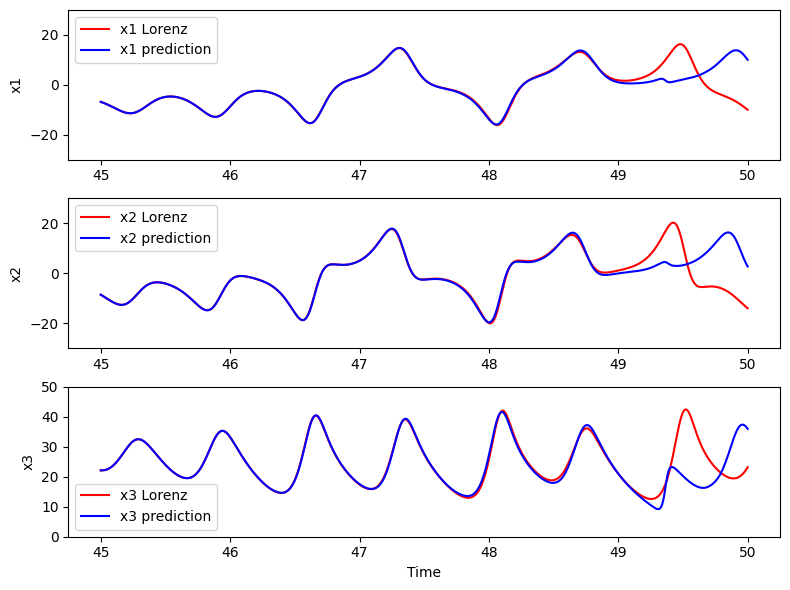

In [ ]:
## Train for 3 variables

# Prepare data
X = list(zip(x1, x2, x3))

split_ratio = 0.9
split_idx = int(len(t) * split_ratio)
t_train, X_train = t[:split_idx], np.array(X[:split_idx])
t_val, X_val = t[split_idx:], np.array(X[split_idx:])


# Set up reservoir
io_size = 3
reservoir_size = 300
sparsity = 0.1
reg_coeff = 1e-4
sv_max = 1.1
w_in_scale = 0.1

rescomp = ReservoirComputer(io_size, reservoir_size, sparsity, reg_coeff, w_in_scale, sv_max)

# Train
rescomp.train(X_train)

# Predict
n_predictions = X_val.shape[0]
X_pred = rescomp.predict(n_predictions)

# Plot prediction
fig, axs = plt.subplots(3, 1, figsize=(8, 6))

axs[0].plot(t_val, X_val[:, 0], label="x1 Lorenz", color="r")
axs[0].plot(t_val, X_pred[:, 0], label="x1 prediction", color="b")
axs[0].set_ylabel("x1")
axs[0].set_ylim([-30, 30])
axs[0].legend()

axs[1].plot(t_val, X_val[:, 1], label="x2 Lorenz", color="r")
axs[1].plot(t_val, X_pred[:, 1], label="x2 prediction", color="b")
axs[1].set_ylabel("x2")
axs[1].set_ylim([-30, 30])
axs[1].legend()

axs[2].plot(t_val, X_val[:, 2], label="x3 Lorenz", color="r")
axs[2].plot(t_val, X_pred[:, 2], label="x3 prediction", color="b")
axs[2].set_ylabel("x3")
axs[2].set_ylim([0, 50])
axs[2].legend()

axs[2].set_xlabel("Time")

fig.tight_layout()
plt.show()

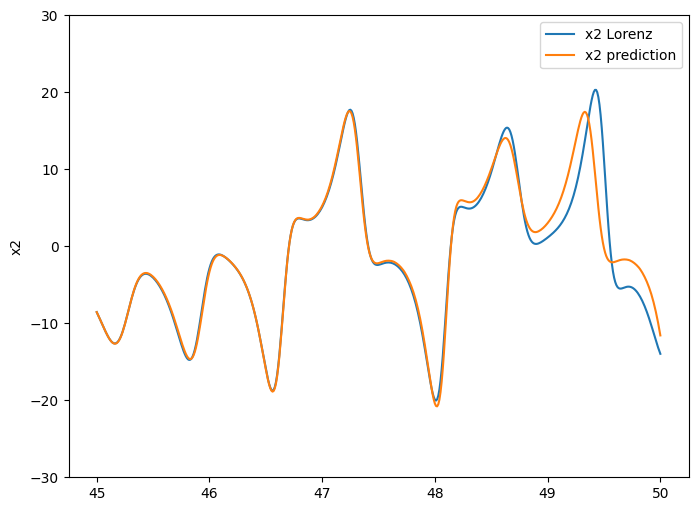

In [ ]:
## Train for x2 only
# Prepare data
X = x2.reshape(-1, 1)

split_ratio = 0.9
split_idx = int(len(t) * split_ratio)
t_train, X_train = t[:split_idx], np.array(X[:split_idx])
t_val, X_val = t[split_idx:], np.array(X[split_idx:])


# Set up reservoir
io_size = 1
reservoir_size = 300
sparsity = 0.1
reg_coeff = 1e-4
sv_max = 2
w_in_scale = 0.05

rescomp = ReservoirComputer(io_size, reservoir_size, sparsity, reg_coeff, w_in_scale, sv_max)

# Train
rescomp.train(X_train)

# Predict
n_predictions = X_val.shape[0]
X_pred = rescomp.predict(n_predictions)

# Plot prediction
plt.figure(figsize=(8, 6))
plt.plot(t_val, X_val, label="x2 Lorenz")
plt.plot(t_val, X_pred, label="x2 prediction")
plt.ylabel("x2")
plt.ylim([-30, 30])
plt.legend()
plt.show()

## Part 3

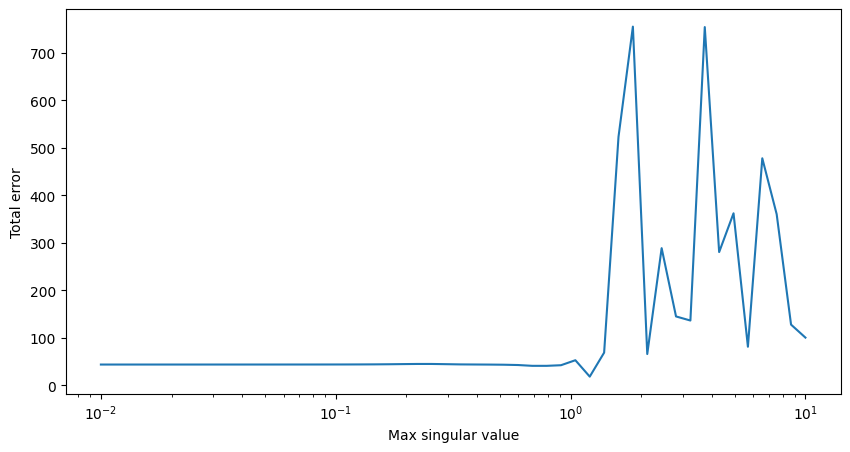

In [ ]:
## Part 3
# Entire Lorenz system

# Prepare data
X = list(zip(x1, x2, x3))

split_ratio = 0.9
split_idx = int(len(t) * split_ratio)
t_train, X_train = t[:split_idx], np.array(X[:split_idx])
t_val, X_val = t[split_idx:], np.array(X[split_idx:])

# Fixed reservoir parameters
io_size = 3
reservoir_size = 300
sparsity = 0.1
reg_coeff = 1e-4
w_in_scale = 0.1

# Run with different maximal singular values
n_predictions = X_val.shape[0]
errors = []
sv_space = np.logspace(-2, 1, 50)
for sv_max in sv_space:
    rescomp = ReservoirComputer(io_size, reservoir_size, sparsity, reg_coeff, w_in_scale, sv_max)
    rescomp.train(X_train)
    n_predictions = X_val.shape[0]
    X_pred = rescomp.predict(n_predictions)

    rmse = np.mean((X_pred - X_val) ** 2)
    errors.append(rmse)

# Plot total error
plt.figure(figsize=(10, 5))
plt.plot(sv_space, errors)
plt.ylabel("Total error")
plt.xlabel("Max singular value")
plt.xscale("log")
plt.show()


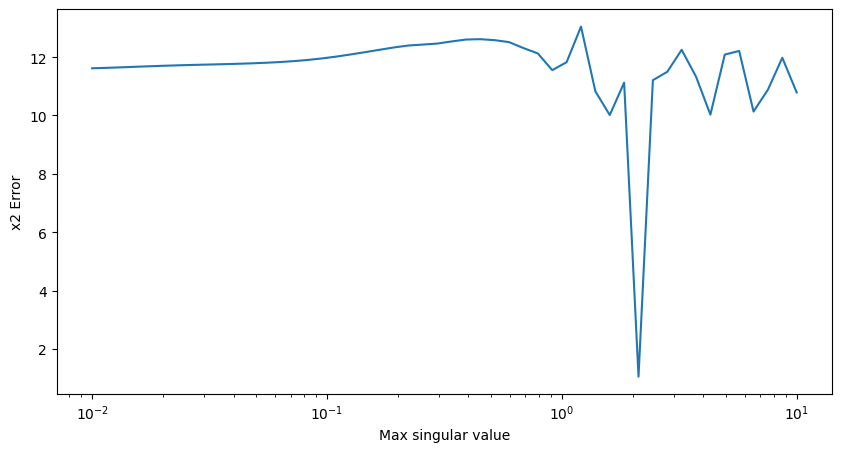

In [ ]:
## Part 3
# Only x2

X = x2.reshape(-1, 1)

split_ratio = 0.9
split_idx = int(len(t) * split_ratio)
t_train, X_train = t[:split_idx], np.array(X[:split_idx])
t_val, X_val = t[split_idx:], np.array(X[split_idx:])


# Fixed reservoir parameters
io_size = 1
reservoir_size = 300
sparsity = 0.1
reg_coeff = 1e-4
w_in_scale = 0.05

# Run with different maximal singular values
n_predictions = X_val.shape[0]
errors = []
sv_space = np.logspace(-2, 1, 50)
for sv_max in sv_space:
    rescomp = ReservoirComputer(io_size, reservoir_size, sparsity, reg_coeff, w_in_scale, sv_max)
    rescomp.train(X_train)
    n_predictions = X_val.shape[0]
    X_pred = rescomp.predict(n_predictions)

    rmse = np.sqrt(np.mean((X_pred - X_val) ** 2))
    errors.append(rmse)

# Plot total error
plt.figure(figsize=(10, 5))
plt.plot(sv_space, errors)
plt.ylabel("x2 Error")
plt.xlabel("Max singular value")
plt.xscale("log")
plt.show()

## Part 4

In [ ]:
# Estimate Lyapunov exponent

import numpy as np
import numba

@numba.njit
def lyapunov_exponent(sigma, rho, beta, dt, n_steps, initial_conditions, epsilon):
    def lorenz(x, y, z):
        dx_dt = sigma * (y - x)
        dy_dt = x * (rho - z) - y
        dz_dt = x * y - beta * z
        return dx_dt, dy_dt, dz_dt

    def runge_kutta(x, y, z, dt):
        # Runge-Kutta 4
        k1x, k1y, k1z = lorenz(x, y, z)
        k2x, k2y, k2z = lorenz(x + 0.5 * dt * k1x, y + 0.5 * dt * k1y, z + 0.5 * dt * k1z)
        k3x, k3y, k3z = lorenz(x + 0.5 * dt * k2x, y + 0.5 * dt * k2y, z + 0.5 * dt * k2z)
        k4x, k4y, k4z = lorenz(x + dt * k3x, y + dt * k3y, z + dt * k3z)
        x += dt * (k1x + 2*k2x + 2*k3x + k4x) / 6
        y += dt * (k1y + 2*k2y + 2*k3y + k4y) / 6
        z += dt * (k1z + 2*k2z + 2*k3z + k4z) / 6
        return x, y, z

    # Main inital conditions
    x0, y0, z0 = initial_conditions
    # Perturbed inital conditions
    x1, y1, z1 = initial_conditions + epsilon

    sum_log_d = 0.0
    for _ in range(n_steps):
        # Update main trajectory
        x0, y0, z0 = runge_kutta(x0, y0, z0, dt)

        # Update perturbed trajectory
        x1, y1, z1 = runge_kutta(x1, y1, z1, dt)

        # Calculate distance between the main and perturbed trajectories.
        dist = np.sqrt((x1 - x0)**2 + (y1 - y0)**2 + (z1 - z0)**2)

        # Accumulate the logarithm of the distance ratio
        sum_log_d += np.log(dist / epsilon)

        # Normalize the perturbation
        norm = np.sqrt((x1 - x0)**2 + (y1 - y0)**2 + (z1 - z0)**2)
        x1, y1, z1 = x0 + (x1 - x0) * epsilon / norm, y0 + (y1 - y0) * epsilon / norm, z0 + (z1 - z0) * epsilon / norm

    # Compute average logarithmic divergence and scale by time step
    return sum_log_d / (n_steps * dt)

# Parameters
sigma = 10
rho = 28
beta = 8 / 3
dt = 0.01
iter_num = 1_000_000
initial_conditions = np.array([1.0, 1.0, 1.0])
epsilon = 1e-6

lyapunov = lyapunov_exponent(sigma, rho, beta, dt, iter_num, initial_conditions, epsilon)
print(f"Estimated largest Lyapunov exponent: {lyapunov}")


Estimated largest Lyapunov exponent: 0.9052059699389207


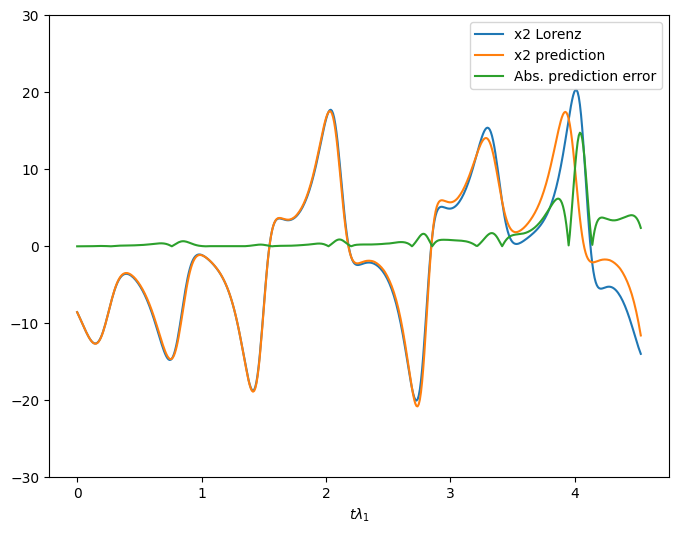

In [ ]:
# Plot vs Lyapunov time

X = x2.reshape(-1, 1)

split_ratio = 0.9
split_idx = int(len(t) * split_ratio)
t_train, X_train = t[:split_idx], np.array(X[:split_idx])
t_val, X_val = t[split_idx:], np.array(X[split_idx:])


# Set up reservoir
io_size = 1
reservoir_size = 300
sparsity = 0.1
reg_coeff = 1e-4
sv_max = 2
w_in_scale = 0.05

rescomp = ReservoirComputer(io_size, reservoir_size, sparsity, reg_coeff, w_in_scale, sv_max)

# Train
rescomp.train(X_train)

# Predict
n_predictions = X_val.shape[0]
X_pred = rescomp.predict(n_predictions)

# Calculate error
error = np.abs(X_pred - X_val)

# Change t to Lyapunov time
lambda_1 = 0.906
t_val = (t_val - t_val[0]) * lambda_1

# Plot prediction
plt.figure(figsize=(8, 6))
plt.plot(t_val, X_val, label="x2 Lorenz")
plt.plot(t_val, X_pred, label="x2 prediction")
plt.plot(t_val, error, label='Abs. prediction error')
plt.xlabel(r'$t\lambda_1$')
plt.ylim([-30, 30])
plt.legend()
plt.show()


